LG AI hackathon Smart Factory
[대회 링크](https://dacon.io/competitions/official/236055/overview/description)

# Data Description

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


# MODULE IMPORT

In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, f1_score

import tensorflow as tf 

# warning message delete 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37)

Mounted at /content/drive


# 0.Data Load

In [32]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [3]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

# 1.Preprocessing

## 1.2 Missing Values 

In [33]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [34]:
train_df.loc[train_df['Y_Class']==0]  # 88 rows 
train_df.loc[train_df['Y_Class']==1]  # 407 rows 
train_df.loc[train_df['Y_Class']==2]  # 103 rows 

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
1,2,0.541819,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
3,2,0.537325,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
5,2,0.537833,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.16,51.25,56.01,37.41,71.37,0.0,0.0,0.0,0.0,0.0
7,2,0.540003,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,39.00,35.95,59.51,30.49,72.77,0.0,0.0,0.0,0.0,0.0
9,2,0.538049,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,34.40,35.88,50.36,38.45,71.42,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,2,0.537465,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,49.92,54.66,50.56,48.63,62.17,1.0,0.0,0.0,0.0,0.0
564,2,0.540106,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,57.94,55.84,53.24,56.72,64.17,1.0,0.0,0.0,0.0,0.0
570,2,0.534951,T100306,O_31,6.0,90.0,0.0,45.0,10.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
572,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [35]:
for i in range(2): 
    train_df = train_df.append(train_df.loc[train_df['Y_Class']==0])
train_df.loc[train_df['Y_Class']==0]  # 352 rows

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
22,0,0.517719,T100304,T_31,2.0,102.0,0.0,45.0,11.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
23,0,0.519090,T100304,T_31,2.0,102.0,0.0,45.0,11.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
28,0,0.521249,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
34,0,0.521524,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,55.03,52.24,55.33,57.49,67.31,1.0,0.0,0.0,0.0,0.0
66,0,0.524408,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0,0.522340,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,51.71,59.64,54.61,57.05,63.18,1.0,0.0,0.0,0.0,0.0
584,0,0.519519,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
585,0,0.515214,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
594,0,0.524022,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,49.47,53.07,50.89,55.10,66.49,1.0,0.0,0.0,0.0,0.0


In [36]:
for i in range(2): 
    train_df = train_df.append(train_df.loc[train_df['Y_Class']==2])
train_df.loc[train_df['Y_Class']==2]  # 412 rows

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
1,2,0.541819,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
3,2,0.537325,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
5,2,0.537833,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.16,51.25,56.01,37.41,71.37,0.0,0.0,0.0,0.0,0.0
7,2,0.540003,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,39.00,35.95,59.51,30.49,72.77,0.0,0.0,0.0,0.0,0.0
9,2,0.538049,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,34.40,35.88,50.36,38.45,71.42,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,2,0.537465,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,49.92,54.66,50.56,48.63,62.17,1.0,0.0,0.0,0.0,0.0
564,2,0.540106,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,57.94,55.84,53.24,56.72,64.17,1.0,0.0,0.0,0.0,0.0
570,2,0.534951,T100306,O_31,6.0,90.0,0.0,45.0,10.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
572,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [39]:
train_df.loc[train_df['Y_Class']==0]  # 352 rows 
train_df.loc[train_df['Y_Class']==1]  # 407 rows 
train_df.loc[train_df['Y_Class']==2]  # 412 rows 

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
22,0,0.517719,T100304,T_31,2.0,102.0,0.0,45.0,11.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
23,0,0.519090,T100304,T_31,2.0,102.0,0.0,45.0,11.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
28,0,0.521249,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
34,0,0.521524,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,55.03,52.24,55.33,57.49,67.31,1.0,0.0,0.0,0.0,0.0
66,0,0.524408,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0,0.522340,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,51.71,59.64,54.61,57.05,63.18,1.0,0.0,0.0,0.0,0.0
584,0,0.519519,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
585,0,0.515214,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
594,0,0.524022,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,49.47,53.07,50.89,55.10,66.49,1.0,0.0,0.0,0.0,0.0


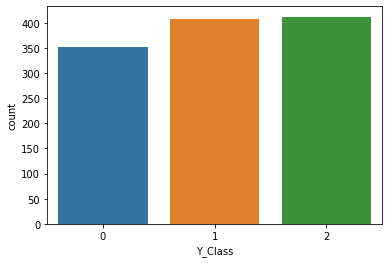

In [41]:
sns.countplot(x='Y_Class', data=train_df);

## 1.3 Encoding


In [42]:
# # Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['LINE', 'PRODUCT_CODE']

for i in col:
    train_df[i] = encoder.fit_transform(train_df[i])
    test_df[i] = encoder.fit_transform(test_df[i])

# # correlation
# # print(train_x[['Y_Quality', 'line_pcode']].corr()) 

# 2.Modeling_ML

In [43]:
X_train = train_df.drop(columns=['Y_Class','Y_Quality'])
y_train = train_df['Y_Quality']

test_x = test_df

In [44]:
# Normalization
# from sklearn.preprocessing import MinMaxScaler   
# scaler = MinMaxScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train))
# test_x = pd.DataFrame(scaler.fit_transform(test_x))
# X_train.describe()

In [45]:
test_x.isnull().sum()

LINE            0
PRODUCT_CODE    0
X_1             0
X_2             0
X_3             0
               ..
X_2871          0
X_2872          0
X_2873          0
X_2874          0
X_2875          0
Length: 2877, dtype: int64

## Y_Quality 예측

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

GBR_model = GradientBoostingRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [47]:
preds=GBR_model.predict(test_x)  
print('Done.')

Done.


In [48]:
test_x['Y_Quality'] = preds
test_x  

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,Y_Quality
0,5,2,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528390
1,4,2,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533201
2,4,2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533163
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.524993
4,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.532744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,5,2,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526356
306,4,2,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.524466
307,5,2,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526888
308,5,2,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526567


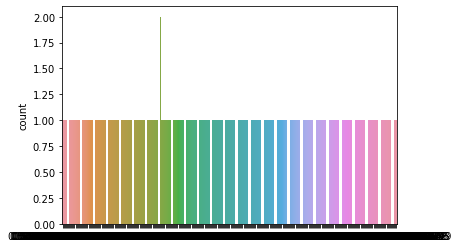

In [49]:
sns.countplot(x=preds);

## 다시 Y_Class 예측

In [50]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [51]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [53]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality']

In [54]:
test_x.isnull().sum()

Y_Quality    0
dtype: int64

In [55]:
preds = GBC_model.predict(test_x)  
print('Done.')   

Done.


In [56]:
preds

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 0, 1,
       0, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,

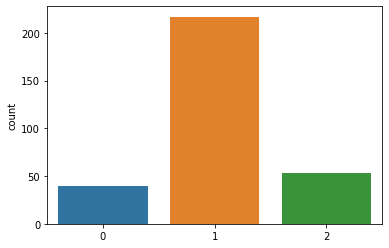

In [57]:
sns.countplot(x=preds);

In [69]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission.csv', index=False)  

## 2.2 LGBM

In [90]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class', 'Y_Quality'])
y_train = train_df[ 'Y_Quality']

X_train

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    random_state=2023)


In [93]:
# hyperparameter - sensitive to setting
## ==> setting is recommended.
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor()
LGBM_model.fit(X_train, y_train) 

LGBM_predict = tf.cast(LGBM_model.predict(X_test) > 0.5, 
                       dtype = tf.float32)

print('Accuracy = ', accuracy_score(LGBM_predict, y_test))
print('Test Report = \n', classification_report(LGBM_predict, y_test))

ValueError: ignored

In [ ]:
test_x

In [ ]:
# test_x = np.array(test_df, dtype=np.float32)
selected_model = LGBM_model 

preds = selected_model.predict(X_test)  
preds

In [ ]:
sns.countplot(x=preds);

In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
y_train = train_df['Y_Class']

In [ ]:
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']   

In [ ]:
# hyperparameter - sensitive to setting
## ==> setting is recommended.
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model.fit(X_train, y_train) 

LGBM_predict = tf.cast(LGBM_model.predict(X_test) > 0.5, 
                       dtype = tf.float32)

print('Accuracy = ', accuracy_score(LGBM_predict, y_test))
print('Test Report = \n', classification_report(LGBM_predict, y_test))

## 2.3 XGBoost

In [ ]:
# hyperparameter setting isn't needed. 
from xgboost import XGBClassifier

Xgboost_model = XGBClassifier()
Xgboost_model.fit(X_train, y_train, eval_metric='aucpr')

Xg_predict = tf.cast(Xgboost_model.predict(X_test) > 0.5, 
                     dtype = tf.float32)

print('Accuracy = ', accuracy_score(Xg_predict, y_test))
print('Test Report = \n', classification_report(Xg_predict, y_test))

In [ ]:
# test_x = np.array(test_df, dtype=np.float32)
selected_model = Xgboost_model 

preds = test_x['Y_Quality']  
preds

In [ ]:
sns.countplot(x=preds);